/vftmp/Qian.Xiao/pid983172/ipykernel_986012/2615922701.py:18: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_uncoudata=xr.open_dataset(pp_root_uncou+"/20040101_results/20040101.ocean_month.nc")['MLD_EN1']
/vftmp/Qian.Xiao/pid983172/ipykernel_986012/2615922701.py:24: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  model_grid_x =xr.open_dataset(pp_root_uncou+"/20040101_results/20040101.ocean_month.nc")['xh'] ##long -100 to -35 xh
/vftmp/Qian.Xiao/pid983172/ipykernel_986012/2615922701.py:25: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.


Before regridding (model): 263153
After regridding (ds_min): 279


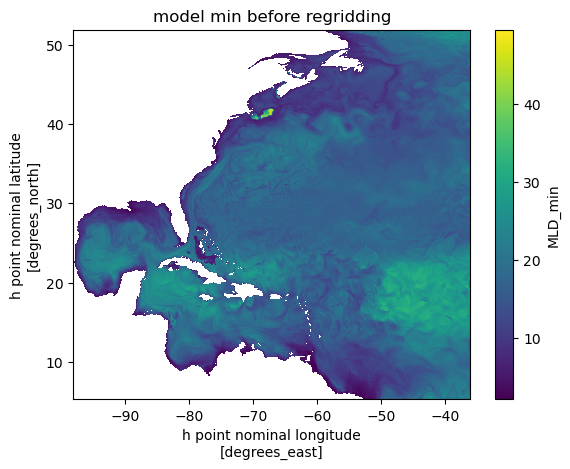

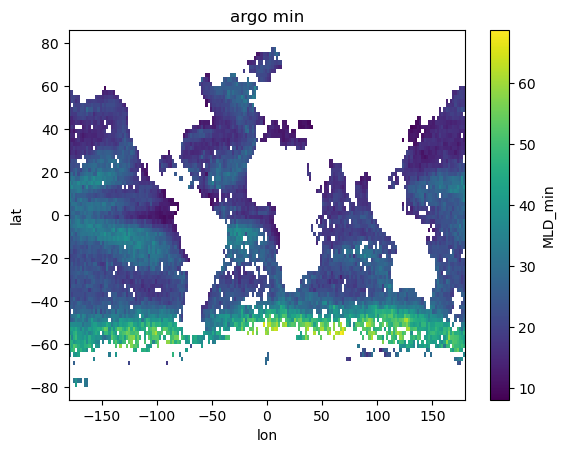

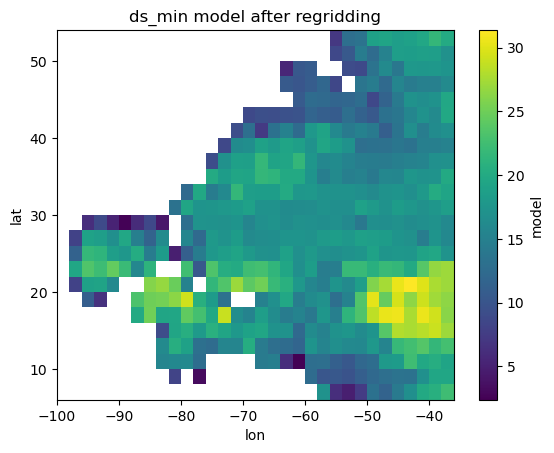

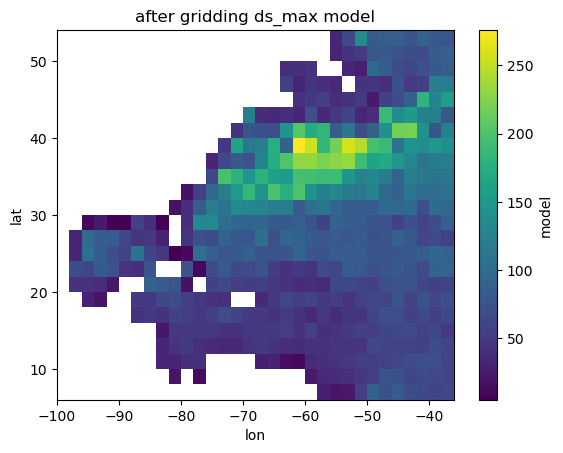

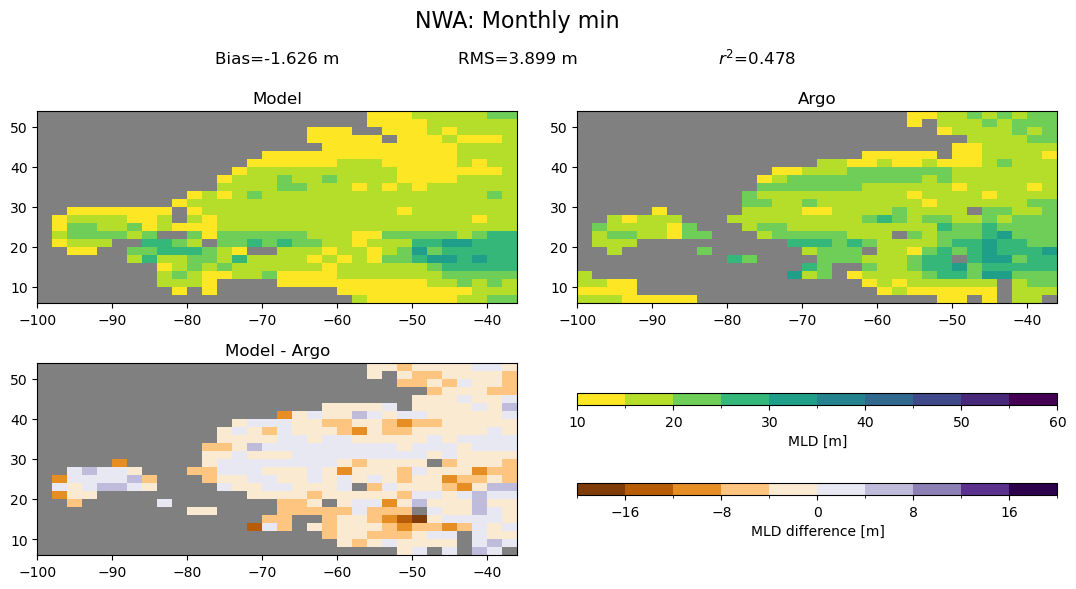

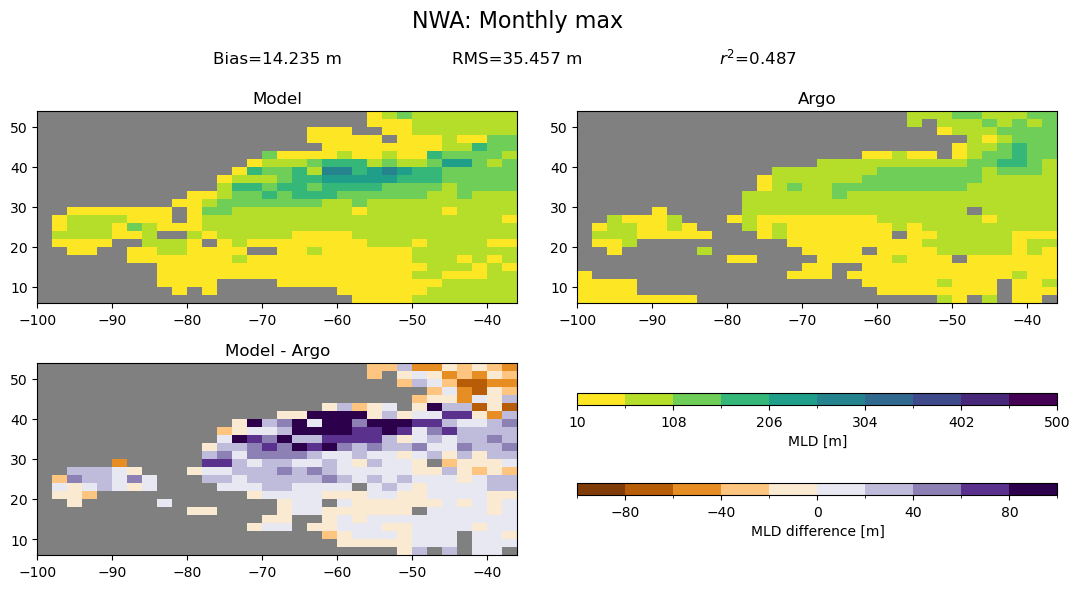

In [1]:
import xarray as xr
import os
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import copy 
import glob
import subprocess
import xesmf as xe

pp_root_uncou = "/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/postProcessing/NWA12.COBALTuncou/"
pp_root_uncou_LAfalse="/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/postProcessing/NWA12.COBALTuncou_LALTFalse/"
pp_root_12_all="/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/c6/postProcessing/NWA12_wave_all/"
pp_root_12_wave="/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/c6/postProcessing/NWA12_wave/"
pp_root_6_all="/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/c6/postProcessing/NWA12_6_all/"
pp_root_6_wave="/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/c6/postProcessing/NWA12_6_wave/"
ds_uncoudata=xr.open_dataset(pp_root_uncou+"/20040101_results/20040101.ocean_month.nc")['MLD_EN1']
ds_uncou_grid=xr.open_dataset(pp_root_uncou+"/20040101_results/20040101.ocean_static.nc")[['geolon_c','geolat_c','geolon_u','geolat_u','geolon_v','geolat_v','geolon','geolat']]
ds_modeldata=ds_uncoudata
ds_modeldata = ds_modeldata.groupby('time.month').mean('time', skipna=True)
ds_uncoudata_2=ds_modeldata

model_grid_x =xr.open_dataset(pp_root_uncou+"/20040101_results/20040101.ocean_month.nc")['xh'] ##long -100 to -35 xh
model_grid_y = xr.open_dataset(pp_root_uncou+"/20040101_results/20040101.ocean_month.nc")['yh'] ## latitude 5 to 55 

static = ds_uncou_grid
Dims = [-100,-35,5,55]
Central = 0.5*(Dims[0]+Dims[1])
CLim1_min=[10,60]
CLim2_min=[-20,20]
CLim1_max=[10,500]
CLim2_max=[-100,100]
expName='NWA'

Options = {
    'experiment name':expName,
    'Dims':Dims,
    'central':Central,
    'CLim1_min':CLim1_min,
    'CLim2_min':CLim2_min,
    'CLim1_max':CLim1_max,
    'CLim2_max':CLim2_max,
}
  
obs_en1 = '/net3/bgr/Datasets/Argo/MLDs_v2/Argo_MLD.mld_pe_anomaly_25.nc'
ds_en1= xr.open_dataset(obs_en1)
MLD_argo=ds_en1
t_argo=MLD_argo.variables['Month']
MLD_argo = MLD_argo.assign_coords(Lon=((MLD_argo.Lon + 180) % 360 - 180))
MLD_argo = MLD_argo.sortby("Lon")
argo_lat=MLD_argo.variables['Lat']
argo_lon=MLD_argo.variables['Lon']
MLD_argo=MLD_argo.variables['MLD_mean']
MLD_argo=xr.DataArray(MLD_argo, dims=["Month", "Lon", "Lat"],coords={'Month': t_argo.values,'Lon': argo_lon.values, 'Lat': argo_lat.values})



ds_obsdata = xr.Dataset()
ds_obsdata['lat']=MLD_argo['Lat'].values
ds_obsdata['lon']=MLD_argo['Lon'].values
ds_obsdata['Month']=MLD_argo['Month'].values
ds_obsdata['MLD_EN1']=(('Month','lon','lat'),MLD_argo.values)

def Set_Plot_ds(cmn_lat,cmn_lon):
    #Using the obs to build the plotting grid
    #Can xarray handle periodic slicing domains?  I'm not sure so adjusting.
    ds_plot = xr.Dataset()
    ds_plot['lat'] = cmn_lat
    ds_plot['lon'] = cmn_lon
    
    return ds_plot

obs_lat = np.copy(ds_obsdata['lat'])
obs_lon = np.copy(ds_obsdata['lon'])
obs_lon[obs_lon<Options['Dims'][0]]+=360
obs_lon[obs_lon>Options['Dims'][1]]-=360
xi = np.argsort(obs_lon)
obs_lon_sort = obs_lon[xi]
lonlims = np.where((obs_lon_sort>Options['Dims'][0])&
                   (obs_lon_sort<Options['Dims'][1]))[0]
latlims = np.where((obs_lat>Options['Dims'][2])&
                   (obs_lat<Options['Dims'][3]))[0]
cmn_lat = obs_lat[latlims]
cmn_lon = obs_lon_sort[lonlims]

ds_min = Set_Plot_ds(cmn_lat,cmn_lon)
ds_max = Set_Plot_ds(cmn_lat,cmn_lon)


model = xr.Dataset()
model["yh"]=ds_modeldata.yh.values
model["xh"]=ds_modeldata.xh.values
model["MLD_min"]=(('yh','xh'),ds_modeldata.min(dim='month').values)
model["MLD_max"]=(('yh','xh'),ds_modeldata.max(dim='month').values)
model = model.assign_coords(lon=(('yh','xh'),ds_uncou_grid['geolon'].values))
model = model.assign_coords(lat=(('yh','xh'),ds_uncou_grid['geolat'].values))
plt.figure()
da_MLD_EN1_wave_ave=xr.DataArray(model["MLD_min"], dims=['yh', 'xh'], coords={'xh': model_grid_x, 'yh': model_grid_y})
da_MLD_EN1_wave_ave.plot()
plt.title('model min before regridding')



obs = xr.Dataset()
obs['lat']=ds_obsdata['lat'].values
obs['lon']=ds_obsdata['lon'].values

obs["MLD_min"]=(('lat','lon'),ds_obsdata.MLD_EN1.min(dim='Month',skipna=False).values.T)
obs["MLD_max"]=(('lat','lon'),ds_obsdata.MLD_EN1.max(dim='Month',skipna=False).values.T)


plt.figure()
da_MLD_EN1_wave_ave=xr.DataArray(obs["MLD_min"], dims=['lat', 'lon'], coords={'lon': obs['lon'], 'lat': obs['lat']})
da_MLD_EN1_wave_ave.plot()
plt.title('argo min')


# regridder_mod = xe.Regridder(model, ds_min, "nearest_s2d",ignore_degenerate=True)  # Explicitly set extrapolation to NaN)
regridder_mod = xe.Regridder(model, ds_min, "bilinear",ignore_degenerate=True,extrap_method=None) 
ds_min['model'] = (('lat','lon'),regridder_mod(model.MLD_min.data))
#####________________________________________________________________________________
# from scipy.interpolate import griddata

# # Flatten model coordinates and data
# lon_model = model['lon'].values.flatten()
# lat_model = model['lat'].values.flatten()
# data_model = model['MLD_min'].values.flatten()

# # Build mask: only use points where data is not NaN
# mask_valid = ~np.isnan(data_model)
# lon_model_valid = lon_model[mask_valid]
# lat_model_valid = lat_model[mask_valid]
# data_model_valid = data_model[mask_valid]

# # Target coordinates from ds_min (obs grid)
# lon_target, lat_target = np.meshgrid(ds_min['lon'].values, ds_min['lat'].values)

# # Interpolate
# interp_min = griddata(
#     points=(lon_model_valid, lat_model_valid),
#     values=data_model_valid,
#     xi=(lon_target, lat_target),
#     method='linear'  # or 'nearest' if you want no interpolation
# )

# # Assign into ds_min
# ds_min['model'] = (('lat', 'lon'), interp_min)
###________________________________________________________________________________
# For model (source)
# lon2d_model, lat2d_model = np.meshgrid(model_grid_x.values, model_grid_y.values)

# model['lon'] = (('yh', 'xh'), lon2d_model)
# model['lat'] = (('yh', 'xh'), lat2d_model)
# def create_corner_bounds_2d(lon, lat):
#     """
#     Create (ny, nx, 4) corner bounds from 1D lon and lat.
#     """
#     lon = np.asarray(lon)
#     lat = np.asarray(lat)

#     dlon = np.diff(lon) / 2
#     dlat = np.diff(lat) / 2

#     lon_b = np.zeros(len(lon) + 1)
#     lat_b = np.zeros(len(lat) + 1)

#     lon_b[1:-1] = lon[:-1] + dlon
#     lon_b[0] = lon[0] - dlon[0]
#     lon_b[-1] = lon[-1] + dlon[-1]

#     lat_b[1:-1] = lat[:-1] + dlat
#     lat_b[0] = lat[0] - dlat[0]
#     lat_b[-1] = lat[-1] + dlat[-1]

#     # Create 2D bounds
#     ny, nx = len(lat), len(lon)
#     lon_bounds = np.zeros((ny, nx, 4))
#     lat_bounds = np.zeros((ny, nx, 4))

#     for j in range(ny):
#         for i in range(nx):
#             # CCW: SW, SE, NE, NW
#             lon_bounds[j, i, 0] = lon_b[i]     # SW
#             lon_bounds[j, i, 1] = lon_b[i+1]   # SE
#             lon_bounds[j, i, 2] = lon_b[i+1]   # NE
#             lon_bounds[j, i, 3] = lon_b[i]     # NW

#             lat_bounds[j, i, 0] = lat_b[j]     # SW
#             lat_bounds[j, i, 1] = lat_b[j]     # SE
#             lat_bounds[j, i, 2] = lat_b[j+1]   # NE
#             lat_bounds[j, i, 3] = lat_b[j+1]   # NW

#     return lon_bounds, lat_bounds
# lon_b_model, lat_b_model = create_corner_bounds_2d(model_grid_x.values, model_grid_y.values)
# model['lon_b'] = (('yh', 'xh', 'nv4'), lon_b_model)
# model['lat_b'] = (('yh', 'xh', 'nv4'), lat_b_model)



# lon_tgt, lat_tgt = np.meshgrid(ds_min['lon'].values, ds_min['lat'].values)
# ds_min['lon'] = (('lat', 'lon'), lon_tgt)
# ds_min['lat'] = (('lat', 'lon'), lat_tgt)

# lon_b_tgt, lat_b_tgt = create_corner_bounds_2d(ds_min['lon'].values[0, :], ds_min['lat'].values[:, 0])
# ds_min['lon_b'] = (('lat', 'lon', 'nv4'), lon_b_tgt)
# ds_min['lat_b'] = (('lat', 'lon', 'nv4'), lat_b_tgt)


# regridder_cons = xe.Regridder(
#     model,
#     ds_min,
#     method="conservative",
#     extrap_method=None,
#     ignore_degenerate=True
# )

# ds_min['model'] = (('lat', 'lon'), regridder_cons(model['MLD_min']))
#####________________________________________________________________________________
# from pyresample import geometry, kd_tree

# # Source: high-res model
# src_geo_def = geometry.SwathDefinition(
#     lons=model['lon'].values,
#     lats=model['lat'].values
# )

# # Target: coarse obs grid
# lon_target, lat_target = np.meshgrid(ds_min['lon'].values, ds_min['lat'].values)
# tgt_geo_def = geometry.SwathDefinition(
#     lons=lon_target,
#     lats=lat_target
# )
# data_model = model['MLD_min'].values

# # Mask invalid points
# mask_valid = ~np.isnan(data_model)

# # Interpolation with mask-aware nearest
# interpolated = kd_tree.resample_nearest(
#     src_geo_def,
#     data_model,
#     tgt_geo_def,
#     radius_of_influence=50000,  # in meters (e.g., 50 km)
#     fill_value=np.nan
# )
# ds_min['model'] = (('lat', 'lon'), interpolated)

# data_model_max = model['MLD_max'].values

# # Mask invalid points
# mask_valid_max = ~np.isnan(data_model_max)

# # Interpolation with mask-aware nearest
# interpolated_max = kd_tree.resample_nearest(
#     src_geo_def,
#     data_model_max,
#     tgt_geo_def,
#     radius_of_influence=50000,  # in meters (e.g., 50 km)
#     fill_value=np.nan
# )
# ds_max['model'] = (('lat', 'lon'), interpolated_max)
#####________________________________________________________________________________
# # Create a mask where the original model has NaN
# mask = np.isnan(model["MLD_min"].values).astype(float)  # Convert to float for regridding

# # Regrid the mask using nearest-neighbor (preserves exact NaN locations)
# regridder_mask = xe.Regridder(
#     model,
#     ds_min,
#     "nearest_s2d",
#     ignore_degenerate=True
# )
# mask_regridded = regridder_mask(mask)
# plt.figure()
# da_MLD_EN1_mask_ave=xr.DataArray(mask_regridded, dims=['lat', 'lon'], coords={'lon': ds_min['lon'], 'lat': ds_min['lat']})
# da_MLD_EN1_mask_ave.plot()
# plt.title('mask_regridded after regridding')

# # Apply the mask to the regridded data
# ds_min['model'] = ds_min['model'].where(mask_regridded == 0)  # 0 = original was not NaN
#####________________________________________________________________________________


ds_min['obs'] = (('lat','lon'),((ds_obsdata.MLD_EN1.min(dim='Month',skipna=False).values.T[:,xi])[latlims[0]:latlims[-1]+1,lonlims[0]:lonlims[-1]+1]))

ds_max['model'] = (('lat','lon'),regridder_mod(model.MLD_max.data))
# ds_max['model'] = ds_max['model'].where(mask_regridded == 0)  # 0 = original was not NaN

ds_max['obs'] = (('lat','lon'),((ds_obsdata.MLD_EN1.max(dim='Month',skipna=False).values.T[:,xi])[latlims[0]:latlims[-1]+1,lonlims[0]:lonlims[-1]+1]))

ds_min['model'] = ds_min['model'].where(~np.isnan(regridder_mod(model.MLD_min.data)))
ds_max['model'] = ds_max['model'].where(~np.isnan(regridder_mod(model.MLD_max.data)))
ds_min['model'] = ds_min['model'].where(ds_min['model'] > 0)
ds_max['model'] = ds_max['model'].where(ds_max['model'] > 0)

plt.figure()
da_MLD_EN1_wave_ave=xr.DataArray(ds_min['model'], dims=['lat', 'lon'], coords={'lon': ds_min['lon'], 'lat': ds_min['lat']})
da_MLD_EN1_wave_ave.plot()
plt.title('ds_min model after regridding')
print("Before regridding (model):", np.isnan(model["MLD_min"].values).sum())
print("After regridding (ds_min):", np.isnan(ds_min['model'].values).sum())


def ComputeStats(ds):
    plon,plat = np.meshgrid(ds.lon.values,ds.lat.values)
    Mask = ((np.isfinite(ds.model.values))&(np.isfinite(ds.obs.values))&
           (plon>Options['Dims'][0])&
           (plon<Options['Dims'][1])&
           (plat>Options['Dims'][2])&
           (plat<Options['Dims'][3])
          )
    diff = (ds.model - ds.obs).values
    ds['bias']=np.nansum((diff[Mask]*np.cos(plat[Mask]*np.pi/180.)).ravel())/np.nansum((np.cos(plat[Mask]*np.pi/180.)).ravel())
    ds['RMS'] =np.sqrt(np.nansum((diff[Mask]**2*np.cos(plat[Mask]*np.pi/180.)).ravel())/np.nansum((np.cos(plat[Mask]*np.pi/180.)).ravel()))
    ds['r2']  =np.corrcoef(ds.model.values[Mask].ravel(),ds.obs.values[Mask].ravel())[1,0]**2
    return ds
ds_min = ComputeStats(ds_min)
ds_max = ComputeStats(ds_max)
diff=xr.Dataset()    
for ds_plot,method in [[ds_min,'min'],
                       [ds_max,'max']
                      ]:
    cmap = copy.copy(plt.cm.viridis_r)
    cmap2 = copy.copy(plt.cm.PuOr)
    cmap.set_bad('gray')
    cmap2.set_bad('gray')
    levels = np.linspace(Options['CLim1_'+method][0],Options['CLim1_'+method][1],11);
    levels2 = np.linspace(Options['CLim2_'+method][0],Options['CLim2_'+method][1],11);
    
    F = plt.figure(figsize=(12, 6))
    lon = ds_plot['lon'].values
    lat = ds_plot['lat'].values
    mod = ds_plot['model'].values
    obs = ds_plot['obs'].values
    dif = mod-obs
    diff[method] = xr.DataArray(dif, dims=['lat', 'lon'], coords={'lat': lat, 'lon': lon})
    lon,lat = np.meshgrid(lon,lat)
                       
    #ax=F.add_axes([0.1,0.52,0.425,0.32],projection=ccrs.Robinson(central_longitude=Options['central']),facecolor='gray',)
    ax=F.add_axes([0.1,0.52,0.4,0.32])
    cb0 = ax.pcolormesh(lon,
                        lat,
                        mod,
                       shading="auto", 
                       #transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),)
    ax.set_title('Model')
    
    # ax=F.add_axes([0.5,0.52,0.425,0.32],projection=ccrs.Robinson(central_longitude=Options['central']),facecolor='gray')
    ax=F.add_axes([0.55,0.52,0.4,0.32])
    cb1 = ax.pcolormesh(lon,lat,obs,
                       shading="auto", 
                       #transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),)
    ax.set_title('Argo')
    
    # ax=F.add_axes([0.1,0.1,0.425,0.32],projection=ccrs.Robinson(central_longitude=Options['central']),facecolor='gray')
    ax=F.add_axes([0.1,0.1,0.4,0.32])
    cb2 = ax.pcolormesh(lon,lat,dif,
                       shading="auto", 
                       #transform=ccrs.PlateCarree(),
                       cmap=cmap2,
                       norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False),)
    ax.set(title='Model - Argo')
    
    cax1 = F.add_axes([0.55, 0.35, 0.4, 0.02])
    cbar1 = plt.colorbar(cb1,cax=cax1,orientation='horizontal')
    cbar1.set_label('MLD [m]')
    cax2 = F.add_axes([0.55, 0.2, 0.4, 0.02])
    cbar2 = plt.colorbar(cb2,cax=cax2,orientation='horizontal')
    cbar2.set_label('MLD difference [m]')
    
    
    ax = F.add_axes([0.1,0.9,0.8,0.1])
    ax.axis('off')
    ax.set(xlim=(0,1),ylim=(0,1))
    FS=12
    ax.text(0.25,0.2,'Bias={:4.3f} m'.format(ds_plot['bias'].values),fontsize=FS,horizontalalignment='center')
    ax.text(0.5,0.2,'RMS={:4.3f} m'.format(ds_plot['RMS'].values),fontsize=FS,horizontalalignment='center')
    ax.text(0.75,0.2,'$r^2$={:4.3f}'.format(ds_plot['r2'].values),fontsize=FS,horizontalalignment='center')
    FS=16
    ax.text(0.5,0.8,Options['experiment name']+': Monthly '+method,
            fontsize=FS,horizontalalignment='center')
